In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, shutil
ROOT_PROJECT =  os.path.join(os.path.normpath(os.path.join(os.getcwd(), "../")))
sys.path[0] = ROOT_PROJECT

import numpy as np
import os, glob
# import seaborn as sns

import matplotlib
from matplotlib import colors, colorbar
from matplotlib import cm
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats, clear_output

import matplotlib_inline.backend_inline
ipython_format = "retina"
if isinstance(ipython_format, str):
    ipython_format = [ipython_format]
matplotlib_inline.backend_inline.set_matplotlib_formats(*ipython_format)

# plt.style.use('seaborn-whitegrid')
plt.style.use('science')
plt.rcParams['figure.figsize'] = (12.0, 7.0)

from tqdm import tqdm

In [2]:
plt.plot()
plt.close()

In [3]:
import warnings
# warnings.simplefilter("ignore", UserWarning)

import torch

from mcbo import RESULTS_DIR

from mcbo.utils.general_utils import plot_mean_std

from mcbo.factory import task_factory
from mcbo.utils.experiment_utils import run_experiment

import seaborn as sns
from matplotlib.ticker import FixedLocator
from mcbo.utils.general_plot_utils import plot_curves_with_ranked_legends, COLORS, MARKERS, plot_task_regrets

from typing import *
import pandas as pd

In [4]:
from mcbo.optimizers import RandomSearch, LocalSearch, \
    SimulatedAnnealing, GeneticAlgorithm, BoBuilder
from mcbo.optimizers.bo_builder import BO_ALGOS

from analysis.model_fit.model_fit import get_fit_result_dir
from mcbo.utils.experiment_utils import get_opt, get_task_and_search_space
from mcbo.optimizers.bo_builder import BoBuilder

dtype: torch.dtype = torch.float64

In [5]:
import scikit_posthocs as sp
import scipy.stats as stats

In [6]:
figure_save_name = "figure_mcbo"
data_save_name = "data_mcbo"

os.makedirs(f"./{figure_save_name}", exist_ok=True)
os.makedirs(f"./{data_save_name}", exist_ok=True)

In [7]:
ALL_RES_COMB_PATH = f"./{data_save_name}/all_res_comb.csv"

In [8]:
task_ids = ['ackley', 'aig_optimization', 'antibody_design', 'mig_optimization', 'pest', 'rna_inverse_fold']

model_names = ["gp_o", "gp_to", "gp_hed", "gp_ssk", "gp_diff", "lr_sparse_hs"]
acq_opts = ["is", "sa", "ga", "ls"]
tr_names = [None, "basic"]

non_bo_short_names = ["ga", "rs", "sa", "ls", "mab"]

seeds = np.arange(42, 52)

In [9]:
# get aliases

COMB_BO_ALGO = ["Casmopolitan", "BOiLS", "COMBO", "BODi", "BOCS", "BOSS"]
BO_ALGO_FULL_NAME_TO_ALIAS = {}
BO_ALGO_ALIAS_TO_FULL_NAME = {}

task, search_space = get_task_and_search_space(task_id=task_ids[0])

for alias in COMB_BO_ALGO:
    bo_algo_builder = BO_ALGOS[alias]
    opt = bo_algo_builder.build_bo(
        search_space=search_space,
        n_init=20,
        input_constraints=task.input_constraints,
    )
    BO_ALGO_FULL_NAME_TO_ALIAS[opt.name] = alias
    BO_ALGO_ALIAS_TO_FULL_NAME[alias] = opt.name    
    
NON_BO_ALGO_NAMES = []
for non_bo_short_name in non_bo_short_names:
    opt = get_opt(search_space=search_space, task=task, full_opt_name=non_bo_short_name)
    NON_BO_ALGO_NAMES.append(opt.name)

In [10]:
def get_bo_short_name(model_name: str, acq_opt_name: Optional[str], acq_func_name: Optional[str], tr_name: Optional[str]):
    full_opt_name = f"{model_name}__{acq_opt_name}__{acq_func_name}"
    if tr_name is not None:
        if tr_name == "basic":
            full_opt_name += "__tr"
        else:
            raise ValueError(tr_name)
    return full_opt_name

In [11]:
def get_results_dir(task_id: str, opt_short_name: str, seeds: List[int], **task_kwargs) -> str:    
    task, search_space = get_task_and_search_space(task_id=task_id, dtype=dtype, **task_kwargs)
    opt = get_opt(search_space=search_space, task=task, full_opt_name=opt_short_name)
    
    columns = ['Task', 'Optimizer', 'Model', 'Acq opt', 'Acq func', 'TR', 'Seed', 'Eval Num', 'f(x)', 'f(x*)', 'Elapsed Time']
    results = pd.DataFrame(columns=columns)
    
    optname = opt.name
        
    sub_folder_dir = os.path.join(RESULTS_DIR, task.name, optname)
    
    for seed in seeds:
        res_path = os.path.join(sub_folder_dir, f'seed_{seed}_results.csv')
        if not os.path.exists(res_path):
            print(task_id, opt_short_name, seed)
            continue
        df = pd.read_csv(res_path)
        n_rows =  len(df['Eval Num'])
        df['Optimizer'] = [opt.name for _ in range(n_rows)]
        df['Task'] = [task.name for _ in range(n_rows)]
        df['Seed'] = [seed for _ in range(n_rows)]
        df['Model'] = [opt.model_name for _ in range(n_rows)]
        df['Acq opt'] = [opt.acq_opt_name for _ in range(n_rows)]
        df['Acq func'] = [opt.acq_func_name for _ in range(n_rows)]
        df['TR'] = [opt.tr_name for _ in range(n_rows)]
        
        df = df[columns]
        results = pd.concat([results, df], ignore_index=True, sort=False)    
    
    
    return results

In [12]:
all_res = None

if os.path.exists(ALL_RES_COMB_PATH):
    all_res = pd.read_csv(ALL_RES_COMB_PATH, index_col=0)
else:
    for t in range(len(task_ids)):
        task_id = task_ids[t]
        for m in range(len(model_names)):
            for a in range(len(acq_opts)):
                for r in range(len(tr_names)):
                    model_name = model_names[m]
                    acq_opt_name = acq_opts[a]
                    tr_name = tr_names[r]

                    if model_name == "lr_sparse_hs":
                        acq_func_name = "ts" 
                    else:
                        acq_func_name = "ei" 

                    opt_short_name = get_bo_short_name(model_name=model_name, acq_opt_name=acq_opt_name, acq_func_name=acq_func_name, tr_name=tr_name)

                    results = get_results_dir(task_id=task_id, opt_short_name=opt_short_name, seeds=seeds)

                    if all_res is None:
                        all_res = results
                    else:
                        all_res = pd.concat([all_res, results], ignore_index=True)
        for non_bo_short_name in non_bo_short_names:
            results = get_results_dir(task_id=task_id, opt_short_name=non_bo_short_name, seeds=seeds)

            if all_res is None:
                all_res = results
            else:
                all_res = pd.concat([all_res, results], ignore_index=True)
    all_res.to_csv(ALL_RES_COMB_PATH)

In [13]:
all_res.head()

Task              Optimizer   Model Acq opt Acq func     TR  \
0  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   
1  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   
2  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   
3  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   
4  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   

   Seed  Eval Num       f(x)      f(x*)  Elapsed Time  
0    42         1  21.421776  21.421776      0.015356  
1    42         2  21.478069  21.421776      0.030319  
2    42         3  21.674237  21.421776      0.045173  
3    42         4  21.358645  21.358645      0.060107  
4    42         5  21.132280  21.132280      0.074904

In [14]:
print(f"Number of novel algos: {len(all_res.Optimizer.unique()) - len(COMB_BO_ALGO) - len(non_bo_short_name)}")
print(f"Number of optimization runs: {len(all_res) // max(all_res['Eval Num'])}")

Number of novel algos: 44
Number of optimization runs: 3180


### Get rank of mean performance per task

In [15]:
DATA_METHOD_SOURCE="Genetic Algorithm"

ALL_FIT_DATA_PATH = f"./{data_save_name}/data_fit_{DATA_METHOD_SOURCE}.csv"

TASK_IDS = ['rna_inverse_fold', 'ackley', 'mig_optimization', 'aig_optimization', 'pest', 'antibody_design']
SURROGATE_IDS = ['gp_to', 'gp_o', 'gp_diff', 'gp_hed', 'gp_ssk']
SEEDS = np.arange(42, 52)

if os.path.exists(ALL_FIT_DATA_PATH):
    all_data = pd.read_csv(ALL_FIT_DATA_PATH)

else:
    all_data = pd.DataFrame(columns=["Task", "Model", "Seed", "Case", "Num observe", "avg_ll"])
   
    cases = ["train", "test"]
    n_observes = [150]  
    tr_id = None
    
    no_missing_exp = True
    for i in tqdm(range(len(TASK_IDS))): 
        task_id = TASK_IDS[i]
        task, search_space = get_task_and_search_space(task_id=task_id)
        for j, surrogate_id in enumerate(SURROGATE_IDS):
            bo_builder = BoBuilder(model_id=surrogate_id, acq_opt_id="sa", acq_func_id="ei", tr_id=tr_id)
            opt = bo_builder.build_bo(search_space=search_space, n_init=1)            
            for k, case in enumerate(cases): 
                for l, n_observe in enumerate(n_observes):
                    for seed in SEEDS:
                        result_dir = get_fit_result_dir(task_id=task_id, data_method_source=DATA_METHOD_SOURCE, surrogate_id=surrogate_id,
                                            seed=seed, n_observe=n_observe)
                        fit_datapath = os.path.join(result_dir, f"{case}_fit.csv")
                        if not os.path.exists(fit_datapath):
                            print(task_id, seed, surrogate_id, case, n_observe)
                            no_missing_exp = False
                            continue
                        fit_data = pd.read_csv(fit_datapath, index_col=0)
                        entry =  {
                            "Task": task.name,
                            "Model": opt.model_name,
                            "Seed": seed,
                            "Case": case,
                            "Num observe": n_observe,
                            "avg_ll":  fit_data["log-likelihood"].values.mean()
                        }
                        all_data.loc[len(all_data)] = [entry[c] for c in all_data.columns]
    if no_missing_exp:
        all_data.to_csv(ALL_FIT_DATA_PATH)

In [16]:
fit_data = pd.read_csv(ALL_FIT_DATA_PATH, index_col=0)

In [17]:
def plot_fit_regret_correlation(fit_ranks: np.ndarray, regret_ranks: np.ndarray, ax: Optional[plt.Axes] = None) -> Tuple[plt.Axes, float, float]:
    """
    Returns:
        ax: axis containing the fit-regret plot
        correlation: Spearman correlation
        pvalue: Spearman test pvalue
    """
    if ax is None:
        ax = plt.subplot()
    
    X,Y = np.meshgrid(np.arange(1, fit_ranks.max() + 1), np.arange(1, regret_ranks.max() + 1))
        
    res = stats.spearmanr(fit_ranks, regret_ranks)
        
    rank_matrix = np.zeros((fit_ranks.max(), fit_ranks.max()))
    for i in range(len(fit_ranks)):
        rank_matrix[fit_ranks[i] - 1, regret_ranks[i] - 1] += 1
    
    for i in range(max(fit_ranks)):
        for j in range(max(regret_ranks)):
            if rank_matrix[i, j] > 0:
                ax.scatter([i + 1], [j + 1], s=50 * rank_matrix[i, j], color=cmap(res.correlation))
    
    return ax, res.correlation, res.pvalue

In [18]:
TR_ALIAS_TO_NAME = {
    "no-tr": "W/O TR",
    "basic": "W/ TR"
}

ACQ_OPT_ALIAS_TO_NAME = {
    "IS": "HC"
}

def acq_func_alias_to_name(acq_opt: str) -> str:
    if acq_opt in ACQ_OPT_ALIAS_TO_NAME:
        return ACQ_OPT_ALIAS_TO_NAME[acq_opt]
    return acq_opt

In [19]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable


colors = [(1, 1, 0.0), (1, 0, 0)]
cmap = LinearSegmentedColormap.from_list(
        "Custom", colors, N=200)

In [20]:
fit_data

Task     Model  Seed   Case  Num observe    avg_ll
0       RNA Inverse Folding   GP (TO)    42  train          150 -1.673526
1       RNA Inverse Folding   GP (TO)    43  train          150 -1.836138
2       RNA Inverse Folding   GP (TO)    44  train          150 -1.807249
3       RNA Inverse Folding   GP (TO)    45  train          150 -2.872844
4       RNA Inverse Folding   GP (TO)    46  train          150 -1.896336
..                      ...       ...   ...    ...          ...       ...
595  2DD8_S Antibody Design  GP (SSK)    47   test          150 -3.819321
596  2DD8_S Antibody Design  GP (SSK)    48   test          150 -3.904482
597  2DD8_S Antibody Design  GP (SSK)    49   test          150 -3.925454
598  2DD8_S Antibody Design  GP (SSK)    50   test          150 -4.145505
599  2DD8_S Antibody Design  GP (SSK)    51   test          150 -4.106117

[600 rows x 6 columns]

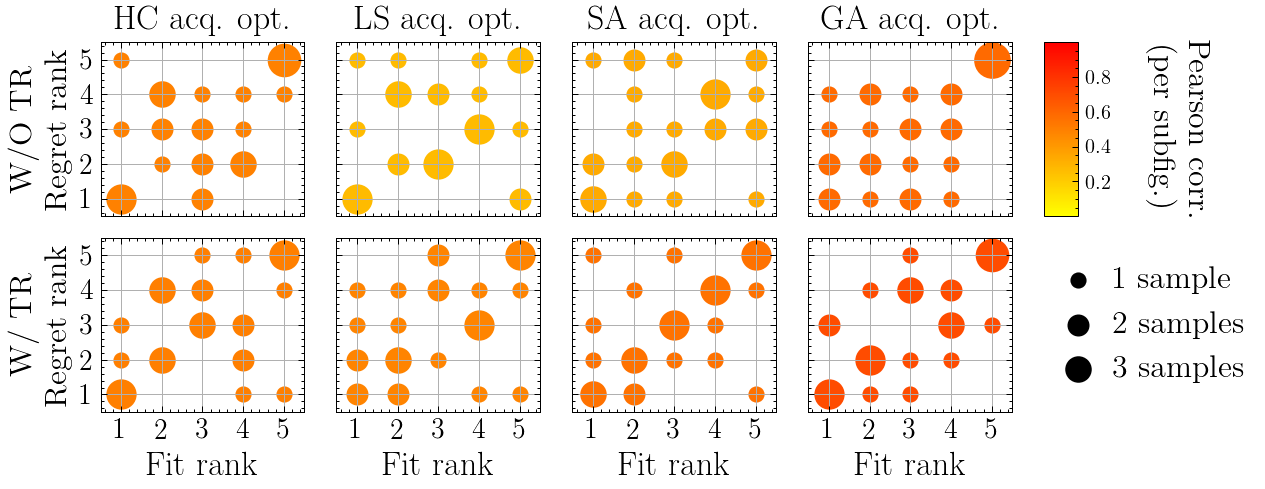

In [21]:
selected_acq_opts = ["IS", "LS", "SA", "GA"]
selected_trs = ["no-tr", "basic"]

selected_fit_case = "test"

selected_budget = 200
selected_fit_num_observe = 150

n_row, n_col = 2, len(selected_acq_opts) + 1

x_fontsize = 15
y_fontsize = 15
y_label_fontsize = 16
x_label_fontsize = 17

xticks_labels_size = 14
yticks_labels_size = 14

legend_fontsize = 18
ax_title_fontsize = 17

fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 1.8, n_row * 1.8), width_ratios=[3 for _ in range(n_col - 1)] + [1], sharey=True, sharex=True)

axes = axes.reshape(n_row, n_col)

for i_row in range(n_row):
    tr_select = selected_trs[i_row]
    for j_col in range(n_col - 1):
        ax = axes[i_row, j_col]
        ax.grid(True)

        ax.tick_params(axis='x', which='major', labelsize=xticks_labels_size)
        ax.tick_params(axis='y', which='major', labelsize=yticks_labels_size)
        
        selected_acq_opt = selected_acq_opts[j_col]
        # ------------------- Regret 
        sub_regret_df = all_res.copy()

        sub_regret_df = sub_regret_df[(sub_regret_df["Acq opt"] == selected_acq_opt)]
        sub_regret_df = sub_regret_df[(sub_regret_df["Eval Num"] == selected_budget)]
        sub_regret_df = sub_regret_df[(sub_regret_df["TR"] == tr_select)]

        sub_regret_df = sub_regret_df[["Task", "Optimizer", "Model", "f(x*)"]].groupby(["Task", "Model"]).mean()

        # ------------------- Fit
        sub_fit_df = fit_data.copy()

        sub_fit_df = sub_fit_df[(sub_fit_df["Case"] == selected_fit_case)]
        sub_fit_df = sub_fit_df[(sub_fit_df["Num observe"] == selected_fit_num_observe)]

        sub_fit_df = sub_fit_df[["Task", "Model", "avg_ll"]].groupby(["Task", "Model"]).mean()

        # ------------------- Combine and rank
        sub_table = sub_regret_df.merge(sub_fit_df,  on=['Task', 'Model'])
        sub_table["neg_avg_ll"] = -sub_table["avg_ll"]
        sub_table.drop("avg_ll", axis=1, inplace=True)

        ys = sub_table.groupby(["Task"]).rank().values.astype(int)
        
        _, correlation, pvalue = plot_fit_regret_correlation(fit_ranks=ys[:, 0], regret_ranks=ys[:, 1], ax=ax)
        
        if pvalue < 0.05:
            pval_info = f"p={pvalue:.1g}"
        else:
            pval_info = f"p={pvalue:.2f}"
        title = ""
        if i_row == 0:
            title += f"{acq_func_alias_to_name(selected_acq_opt)} acq. opt."
        if len(title) == 0:
            title = None
        ax.set_title(title, fontsize=ax_title_fontsize)
        ax.set_xticks(np.arange(1, np.max(ys) + 1))
        ax.set_yticks(np.arange(1, np.max(ys) + 1))
        
        ax.set_xlim(0.5, np.max(ys) + .5)
        ax.set_ylim(0.5, np.max(ys) + .5)
        if j_col == 0:
            ax.set_ylabel(f"{TR_ALIAS_TO_NAME[tr_select]}\nRegret rank", fontsize=y_label_fontsize)
        if i_row == (n_row - 1):
            ax.set_xlabel("Fit rank", fontsize=x_label_fontsize)
            

ax = axes[0, -1]
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="99%", pad=0.0)
cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap), cax=cax, aspect=10, ticks=np.linspace(0, 1, 6)[1:-1])

ax.set_axis_off()
cbar.set_label("Pearson corr.\n(per subfig.)", fontsize=16, rotation=-90, labelpad=50)

ax = axes[1, -1]
for i in range(3):
    ax.scatter([], [], s=50 * (i + 1), label=f"{i + 1} sample{'s' if i > 0 else ''}", c="k")
ax.set_axis_off()
ax.legend(fontsize=16, bbox_to_anchor=(-.4, .5), loc='center left', handletextpad=0.1)

plt.tight_layout()
plt.savefig(f"./{figure_save_name}/fit_to_regret.pdf")
plt.show()

### Performance

In [22]:
def data_key_to_label(k: str):
    if k in BO_ALGO_FULL_NAME_TO_ALIAS:
        k = BO_ALGO_FULL_NAME_TO_ALIAS[k]
    else:
        k = k
    if k == "IS":
        return "HC"
    k = k.replace("LR (sparse_horseshoe)", "LSH")
    k = k.replace("HED-mat52", "HED")
    k = k.replace("Diffusion", "Diff.")
    k = k.replace("turbo", "w/ TR")
    k = k.replace("basic", "w/ TR")
    k = k.replace("no-tr", "w/o TR")
    k = k.replace("Tr-based GA acq optim", "GA w/ TR")
    k = k.replace("IS acq optim", "HC acq optim")
    
    return k

In [23]:
x_fontsize = 15
y_fontsize = 15
y_label_fontsize = 22
x_label_fontsize = 17

xticks_labels_size = 14
yticks_labels_size = 14

legend_fontsize = 18
ax_title_fontsize = 20

In [24]:
final_num_eval = 200

For each task and seed, rank the optimizers.

In [25]:
sub_regret_df = all_res.copy()

sub_regret_df["rank"] = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])[["f(x*)"]].rank()
sub_regret_df.head()

Task              Optimizer   Model Acq opt Acq func     TR  \
0  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   
1  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   
2  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   
3  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   
4  Ackley Function  GP (O) - IS acq optim  GP (O)      IS       EI  no-tr   

   Seed  Eval Num       f(x)      f(x*)  Elapsed Time  rank  
0    42         1  21.421776  21.421776      0.015356  28.5  
1    42         2  21.478069  21.421776      0.030319  29.5  
2    42         3  21.674237  21.421776      0.045173  29.5  
3    42         4  21.358645  21.358645      0.060107  33.0  
4    42         5  21.132280  21.132280      0.074904  25.5

##### For each optimizer, average rank per task, and average these across all tasks to get the overall rank performance of each optimizer at the end of the optimisation

In [26]:
algo_name_to_avg_rank = sub_regret_df[sub_regret_df["Eval Num"] == final_num_eval].groupby(["Optimizer"])["rank"].mean().to_dict()

##### Keep the 2 best mixed and match algorithm, the already published algorithm as well as the standard heuristics

In [27]:
best_unbranded_opt_names = sorted([k for k in algo_name_to_avg_rank if (k not in BO_ALGO_FULL_NAME_TO_ALIAS and k not in NON_BO_ALGO_NAMES)], key=lambda k: algo_name_to_avg_rank[k])

In [28]:
selected_algo_names = best_unbranded_opt_names[:2] + [k for k in BO_ALGO_FULL_NAME_TO_ALIAS.keys() if k in algo_name_to_avg_rank] + NON_BO_ALGO_NAMES

##### Show evolution of rank among them

In [29]:
from scipy.stats import rankdata

In [30]:
sub_regret_df = all_res[all_res.Optimizer.isin(selected_algo_names)].copy()
aux_group = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])
sub_regret_df["rank"] = aux_group[["f(x*)"]].rank()

counts = aux_group.count().values.flatten()
assert np.all(counts[0] == counts)

num_cands = counts[0]

In [31]:
num_evals = np.arange(20, 201)
group_col = "Optimizer"

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df[sub_regret_df.Optimizer.isin(selected_algo_names)]

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T

###### Assess statistical difference

In [32]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

if friedman_test_pvalue >= 0.05:
    print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col, zero_method="pratt") 

test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

In [33]:
data_color = {data_key: COLORS[i % len(COLORS)] for i, data_key in enumerate(opt_to_rank_dict)}
data_marker = {data_key: MARKERS[i % len(MARKERS)] for i, data_key in enumerate(opt_to_rank_dict)}

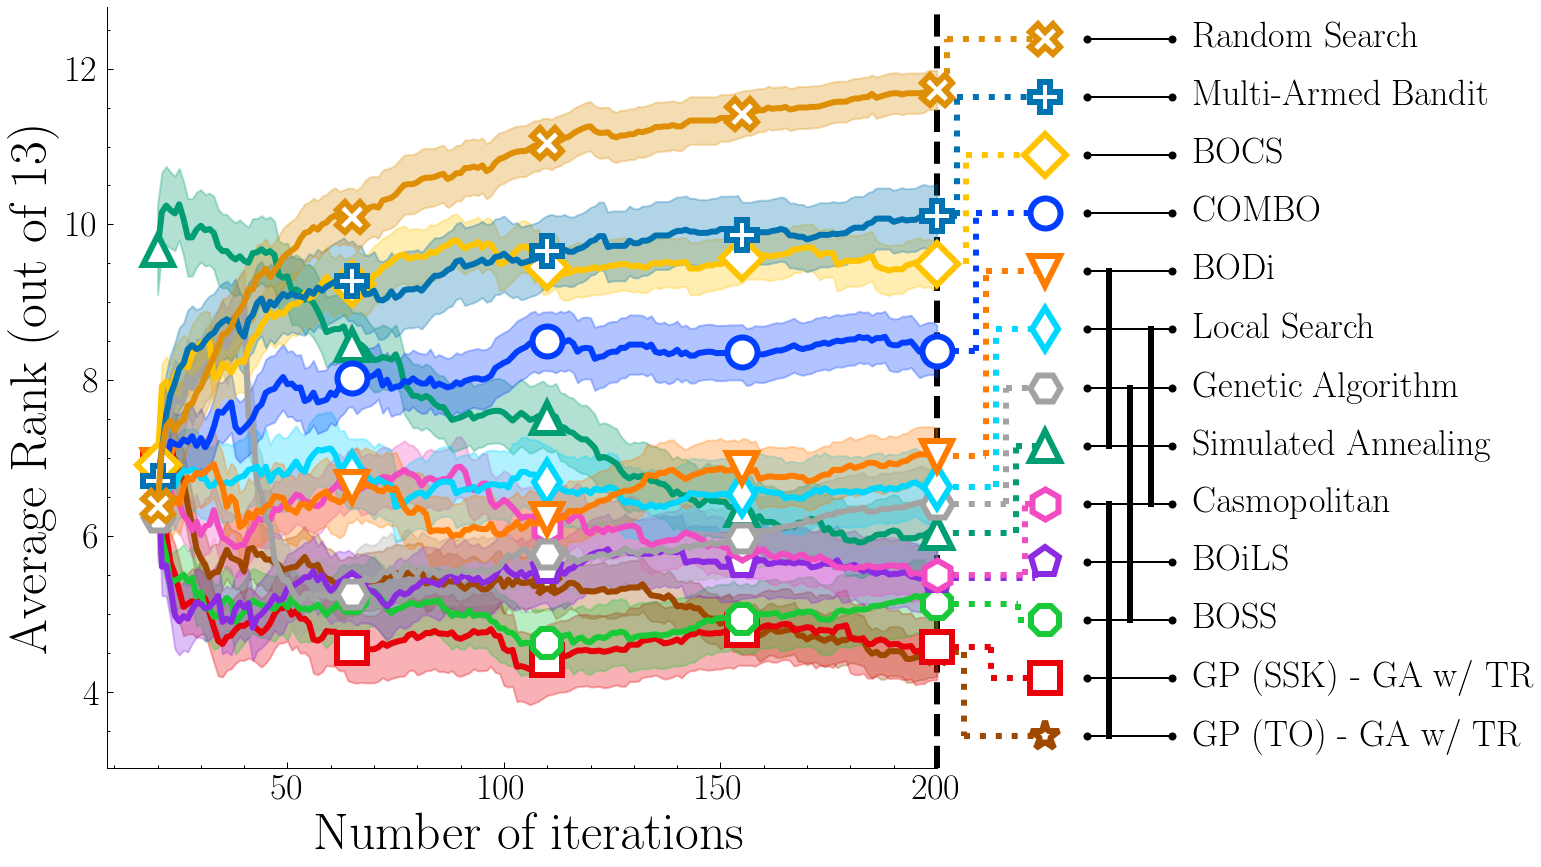

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))

plot_curves_with_ranked_legends(
    ax=ax,
    data_y=opt_to_rank_dict,
    data_x=num_evals,
    show_std_error=True,
    min_is_the_best=True,
    data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map,
    data_color=data_color,
    data_marker=data_marker
)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=26)
ax.set_xlabel("Number of iterations", fontsize=26)
ax.xaxis.set_label_coords(.38, -0.06)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.savefig(f"./{figure_save_name}/avg_rank_comb.pdf")
plt.show()

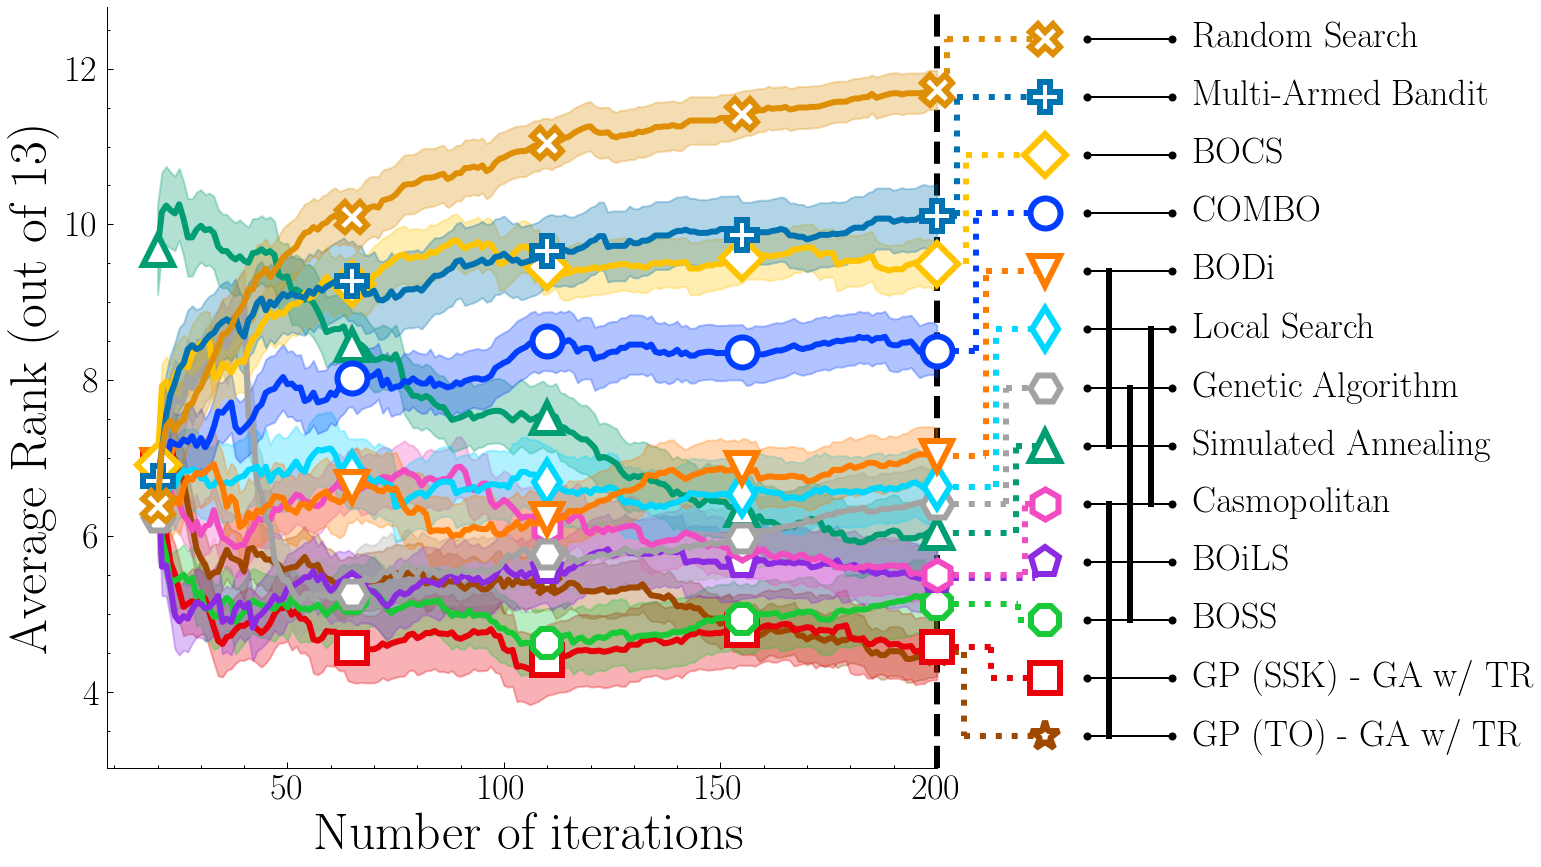

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))

plot_curves_with_ranked_legends(
    ax=ax,
    data_y=opt_to_rank_dict,
    data_x=num_evals,
    show_std_error=True,
    min_is_the_best=True,
    data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map,
    data_color=data_color,
    data_marker=data_marker
)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=26)
ax.set_xlabel("Number of iterations", fontsize=26)
ax.xaxis.set_label_coords(.38, -0.06)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.savefig(f"./{figure_save_name}/avg_rank_comb.pdf")
plt.show()

#### Show results of the selected optimizers on each task as evolution of regret

We now show the evolution of regrets on each subtask, we include the most competitive heuristics SA and GA.

- Should I add for each task the combination that achieved the lowest final regret?

In [35]:
for to_remove_algo in ["Random Search", "Local Search", "Multi-Armed Bandit"]:
    if to_remove_algo in selected_algo_names:
        selected_algo_names.remove(to_remove_algo)

In [36]:
TASK_ID_TO_NAME = {
    'Ackley Function': 'Ackley-20D',
    'EDA Sequence Optimization - Design sin - Ops basic - Pattern basic - Obj both': 'AIG flow tuning',
    '2DD8_S Antibody Design': 'Antibody design',
    'MIG Sequence Optimisation - sqrt - both': 'MIG flow tuning', 
}

def task_id_to_name(task_id: str) -> str:
    return TASK_ID_TO_NAME.get(task_id, task_id)

In [37]:
seeds = np.arange(42, 52)

x_evals = np.arange(0, 200)

ci_level = .95

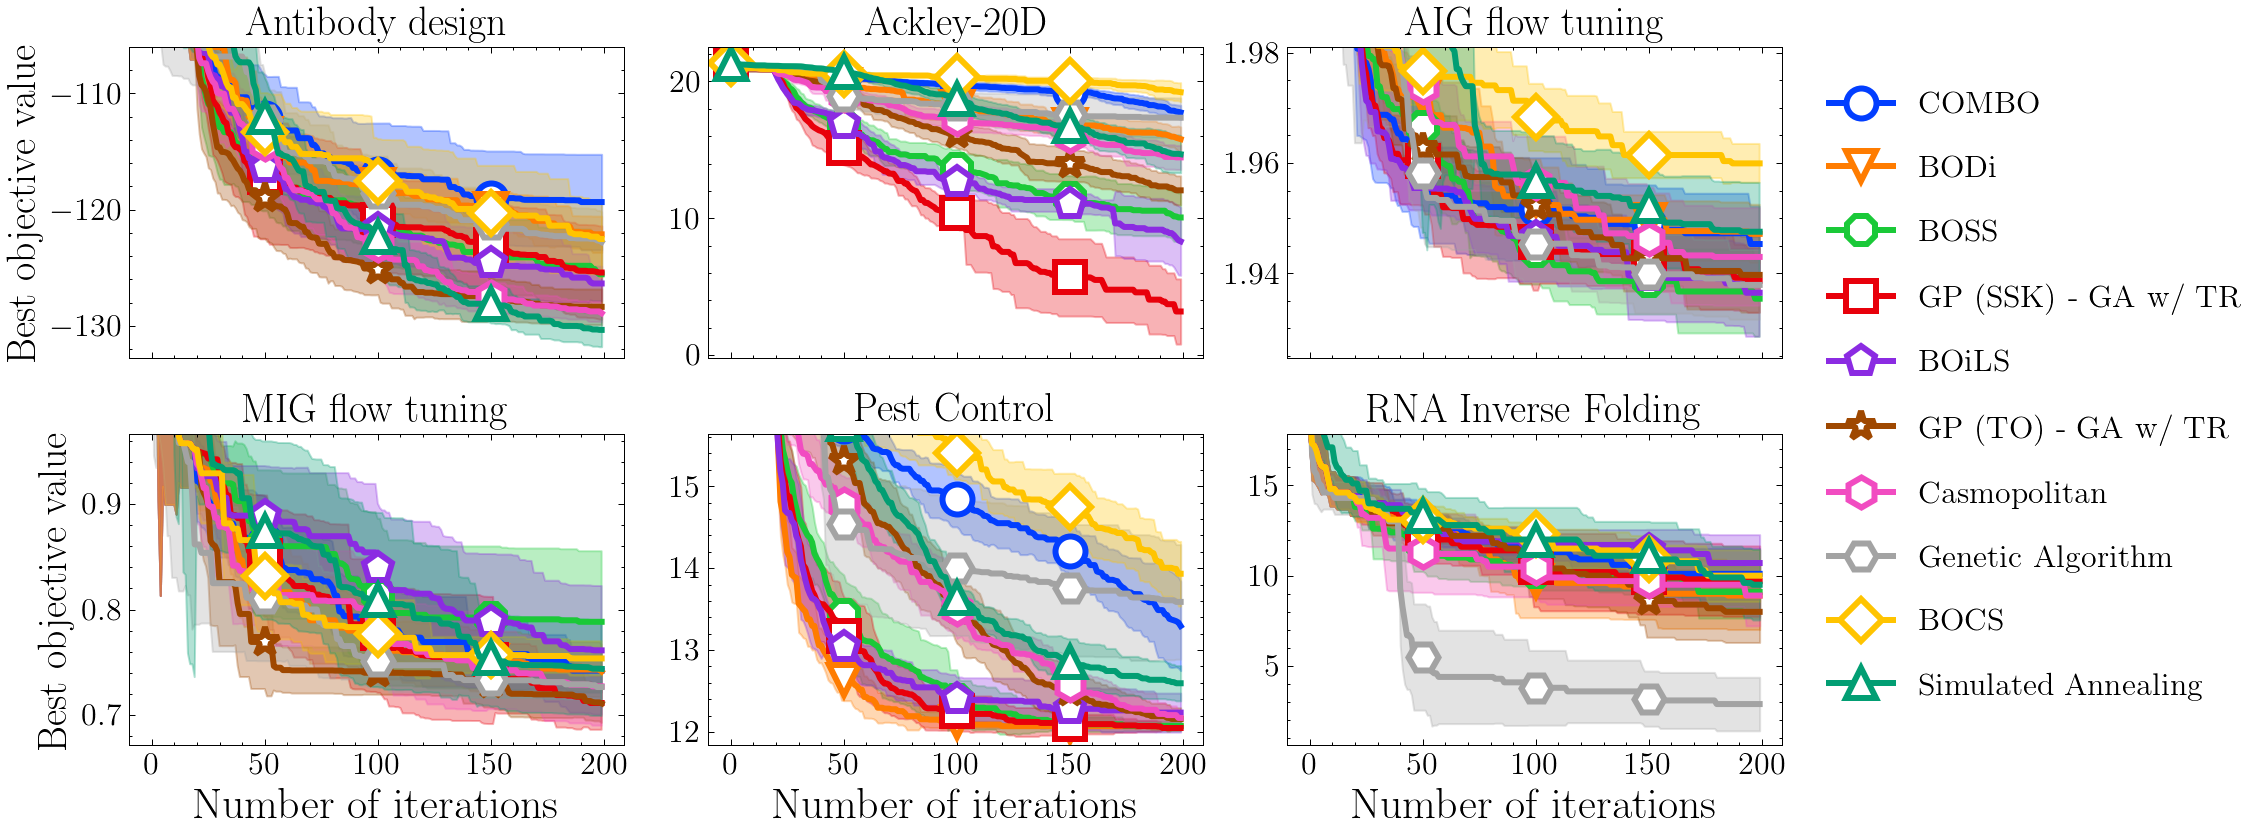

In [38]:
# Grid of subplots when we know n_col and the number of elements to plot
n_el = len(task_ids)

n_col = 3 + 1
n_row = np.ceil(n_el / n_col).astype(int)

fig, axes = plt.subplots(n_row, n_col, figsize=(4 * n_col, 3 * n_row), width_ratios=[3 for _ in range(n_col - 1)] + [1], sharex=True)
legend_ax_aux = axes[0, -1].get_gridspec()
# remove the underlying axes
for ax in axes[:, -1]:
    ax.remove()
    
legend_ax = fig.add_subplot(legend_ax_aux[:, -1])


ind = 0
for task_id, task_group in all_res.groupby("Task"):
    i_row = ind // (n_col - 1)
    j_col = ind % (n_col - 1)
    ax = axes[i_row, j_col]
    
    res_regret_dic = {}
    for opt_name, task_opt_group in task_group.groupby("Optimizer"):
        if opt_name not in selected_algo_names:
            continue
        res = np.array([task_opt_seed_group["f(x*)"].values[x_evals] for _, task_opt_seed_group in task_opt_group.groupby("Seed")])
        res_regret_dic[opt_name] = res
    
    ax = plot_task_regrets(ax=ax, data_x=x_evals, data_y=res_regret_dic, data_color=data_color, data_key_to_label=data_key_to_label,
                      data_marker=data_marker, ci_level=ci_level, show_std_error=False, zoom_end_pct=.7)

    ind += 1
    
    ax.set_title(task_id_to_name(task_id=task_id), fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    if i_row == (n_row - 1):
        ax.set_xlabel("Number of iterations", fontsize=22)
    if j_col == 0:
        ax.set_ylabel("Best objective value", fontsize=20)
        

handles, labels = ax.get_legend_handles_labels()

legend_ax.set_axis_off()
legend_ax.legend(handles, labels, fontsize=16, bbox_to_anchor=(-.4, .5), loc='center left', labelspacing=1.1)

    
plt.tight_layout()    
plt.savefig(f"./{figure_save_name}/regret_all_comb_bests.pdf")
plt.show()



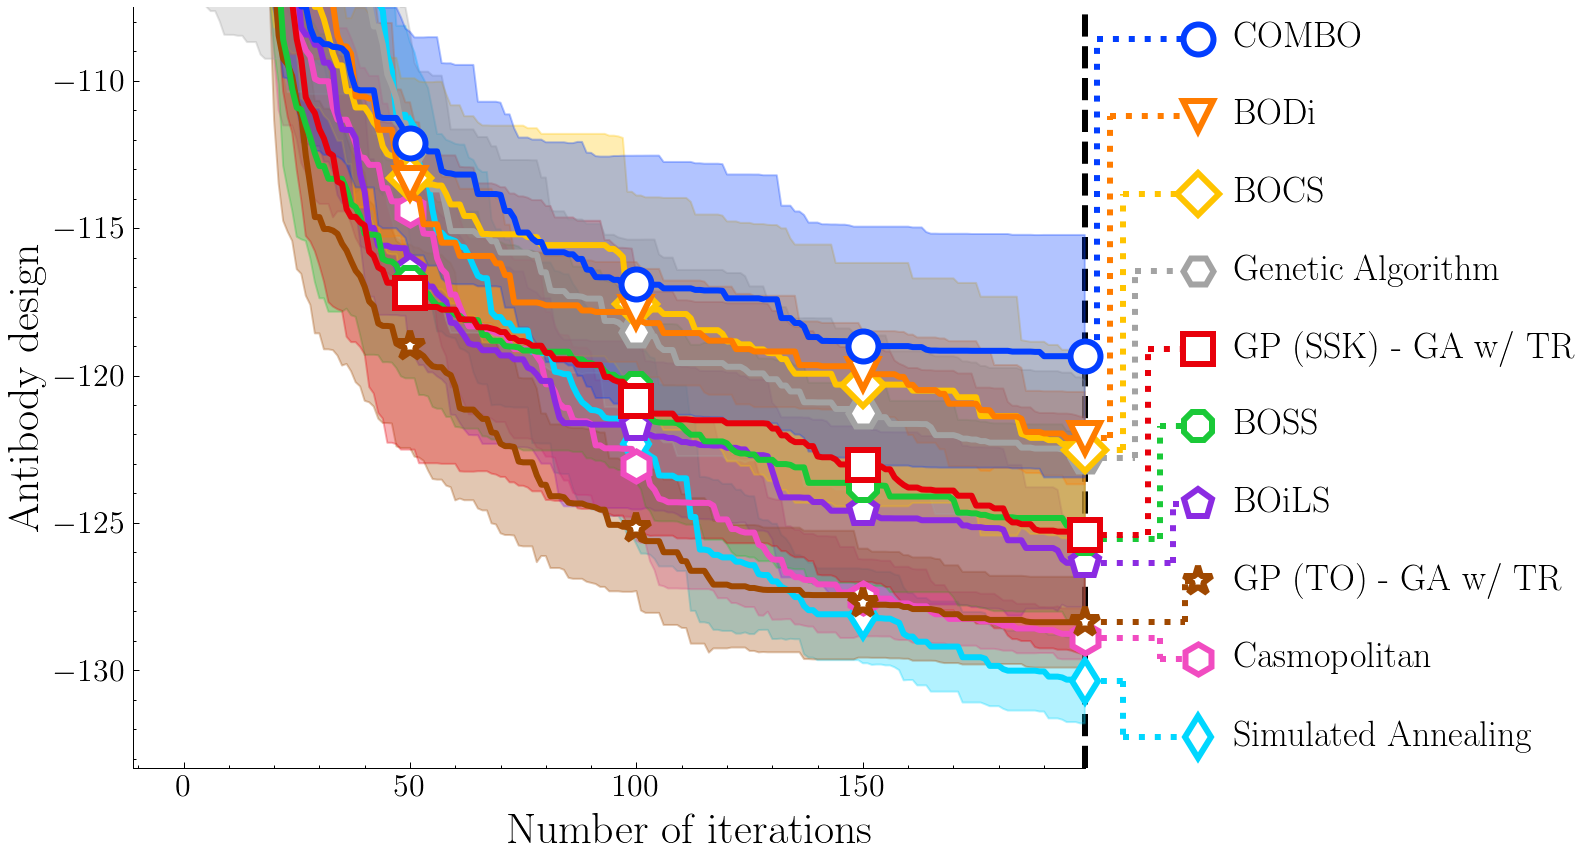

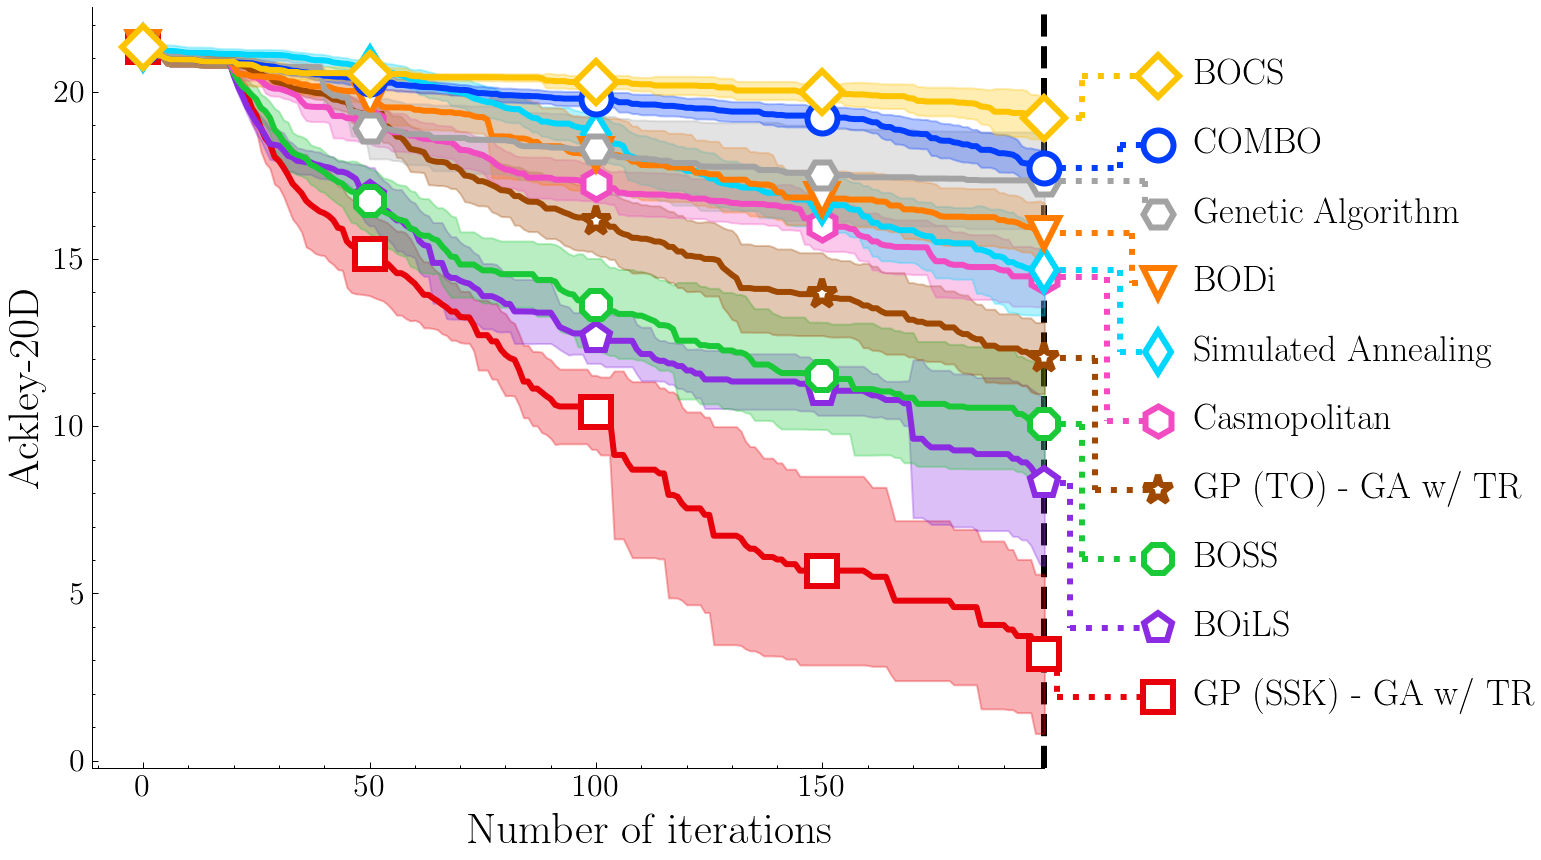

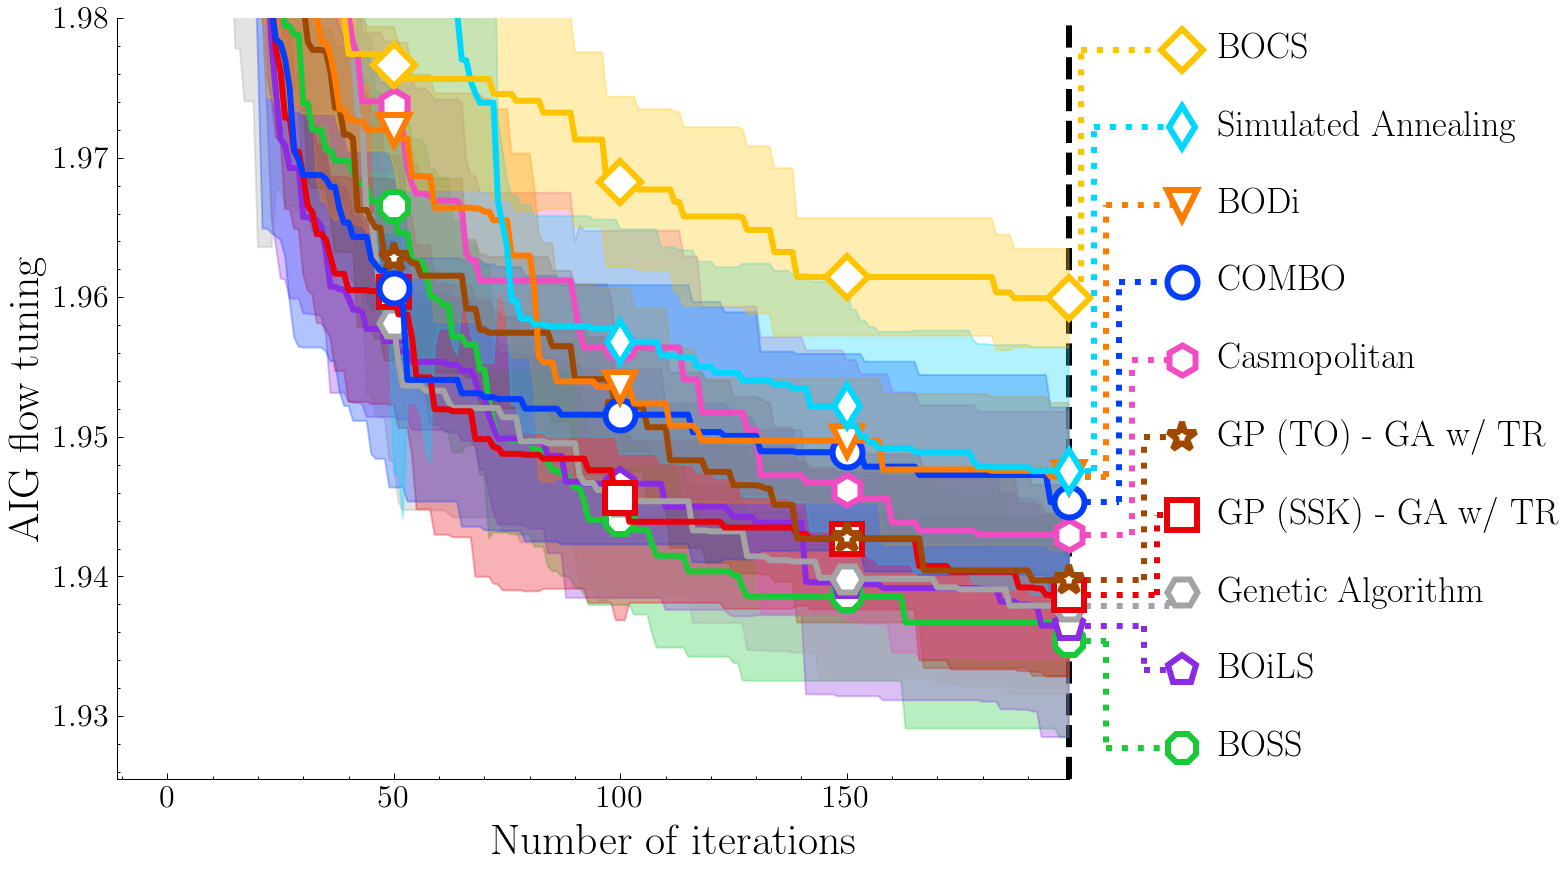

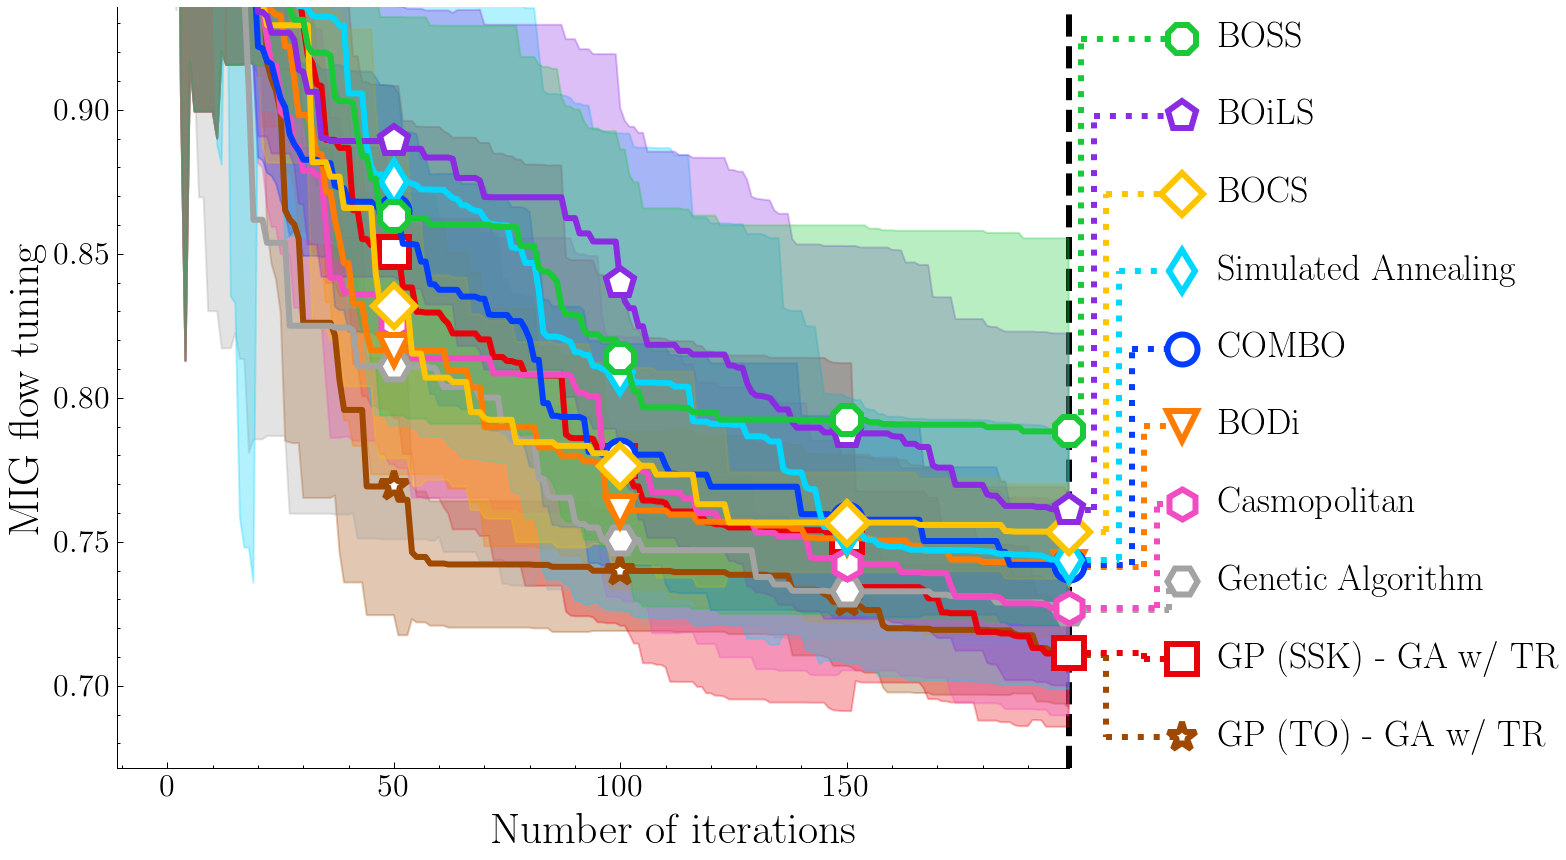

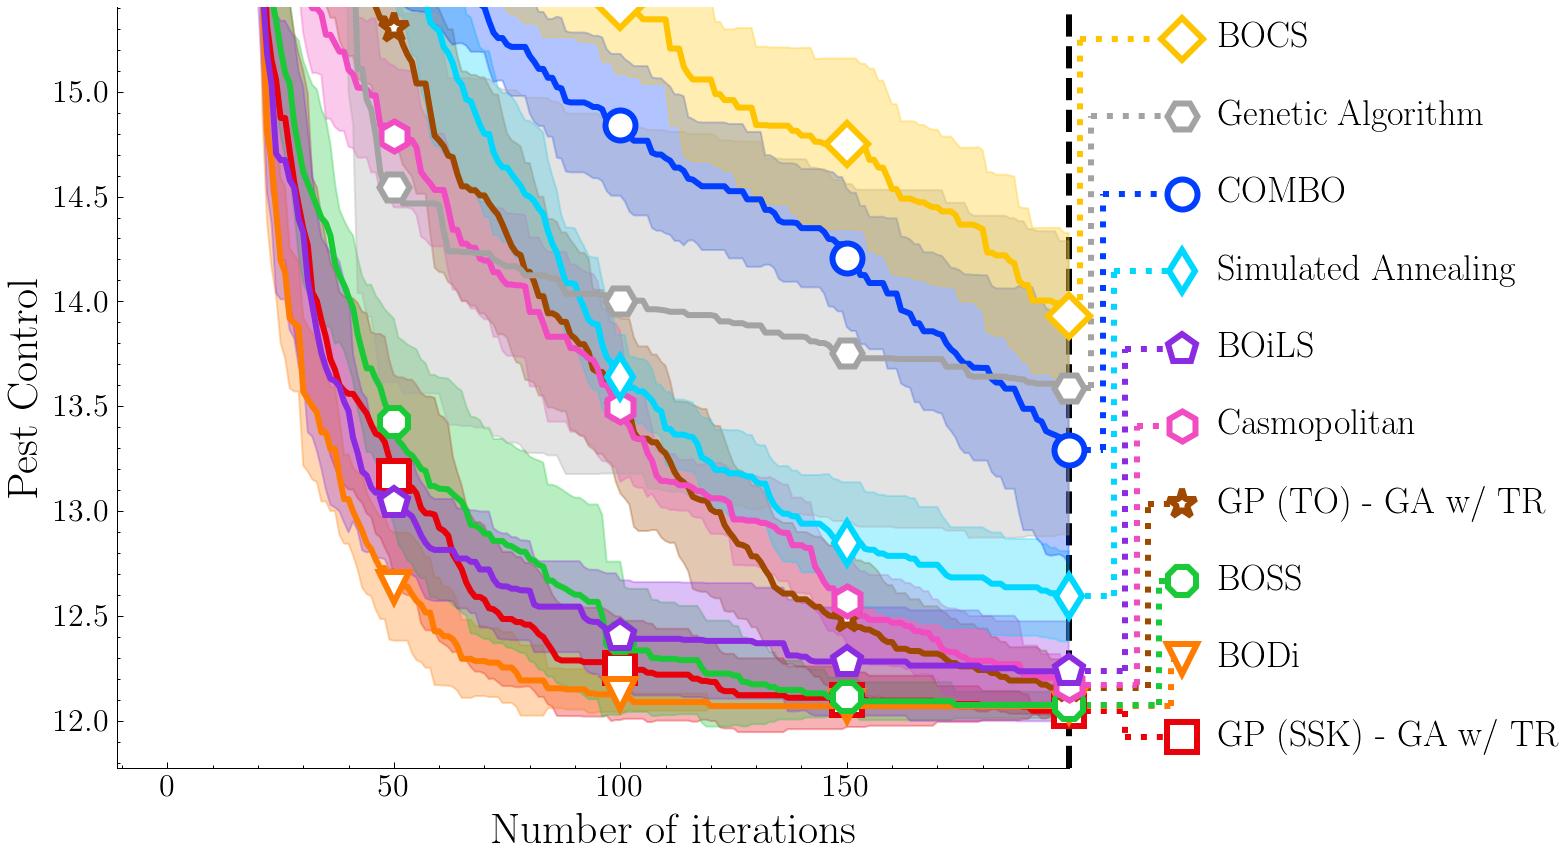

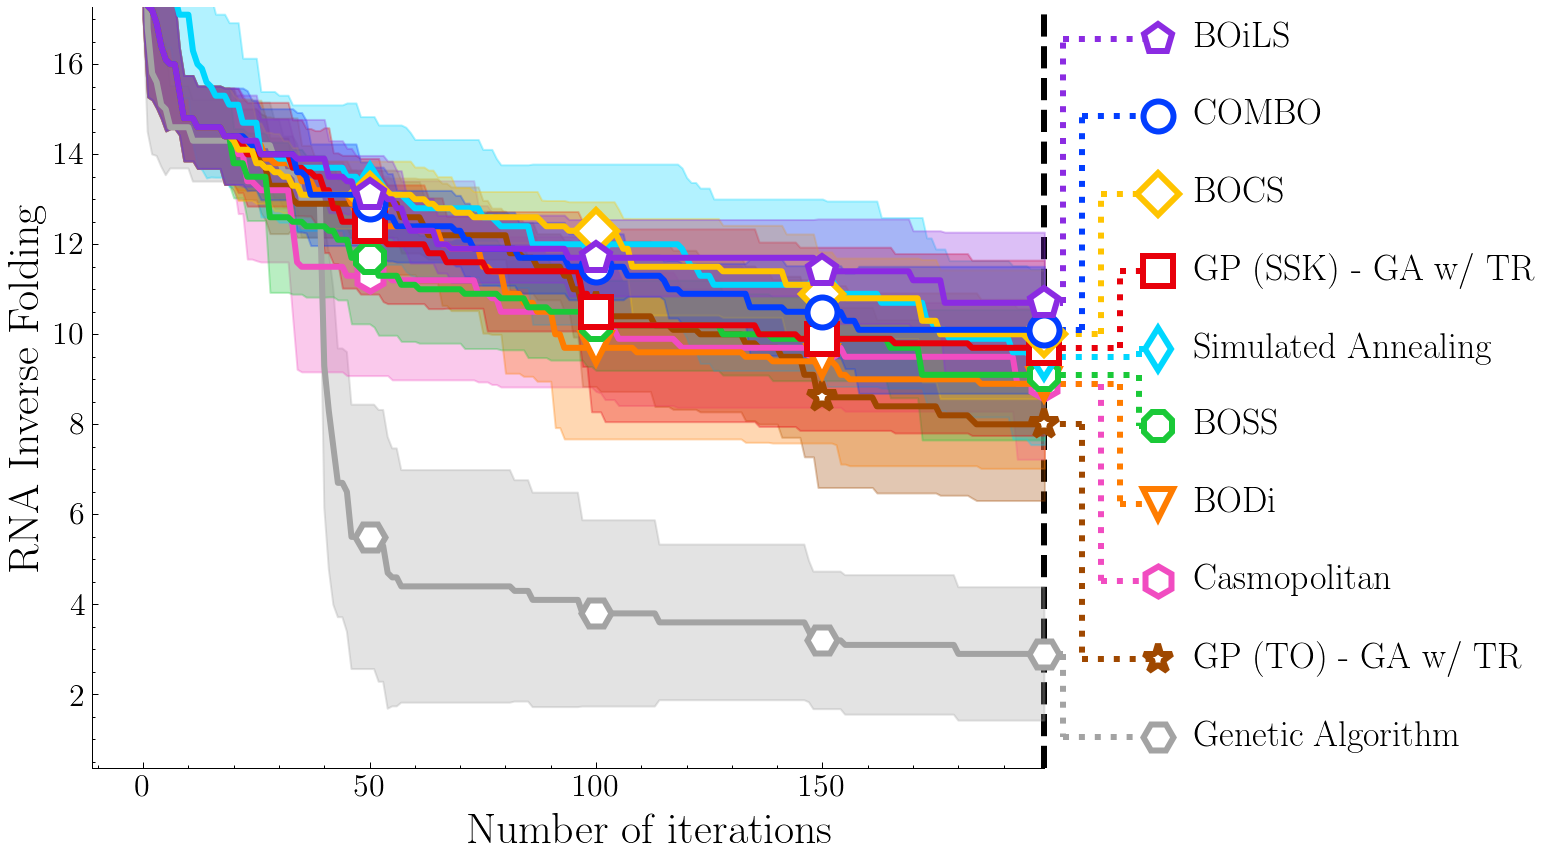

In [39]:
# Grid of subplots when we know n_col and the number of elements to plot
n_el = len(task_ids)

n_col = 2
n_row = np.ceil(n_el / n_col).astype(int)

ind = 0
for task_name, task_group in all_res.groupby("Task"):
    plt.figure(figsize=(10, 7))
    ax = plt.gca()

    res_regret_dic = {}
    for opt_name, task_opt_group in task_group.groupby("Optimizer"):
        if opt_name not in selected_algo_names:
            continue
        res = np.array([task_opt_seed_group["f(x*)"].values[x_evals] for _, task_opt_seed_group in task_opt_group.groupby("Seed")])
        res_regret_dic[opt_name] = res

    plot_curves_with_ranked_legends(ax, data_y=res_regret_dic, data_x=x_evals, data_key_to_label=data_key_to_label, ci_level=.95, zoom_end_pct=.7)
    ind += 1
    
    ax.set_ylabel(task_id_to_name(task_name), fontsize=y_label_fontsize)
    ax.xaxis.set_label_coords(.38, -0.06)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel("Number of iterations", fontsize=22)

#     plt.tight_layout()    
    plt.savefig(f"./{figure_save_name}/regret_{task_name.replace(' ', '_')[:6]}_bests.pdf")
    plt.show()

#### Results aggregated by Model, Acquisition function optimiser, use of TR 

In [40]:
sub_regret_df = all_res.copy()

filtre_out = {"Model": ["no-model"]}

group_col = ["Model"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

aux_groupby = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])
sub_regret_df["rank"] = aux_groupby[["f(x*)"]].rank()

counts = aux_groupby.count().values.flatten()
assert np.all(counts[0] == counts)

num_cands = counts[0]

In [41]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T

###### Assess statistical difference

In [42]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

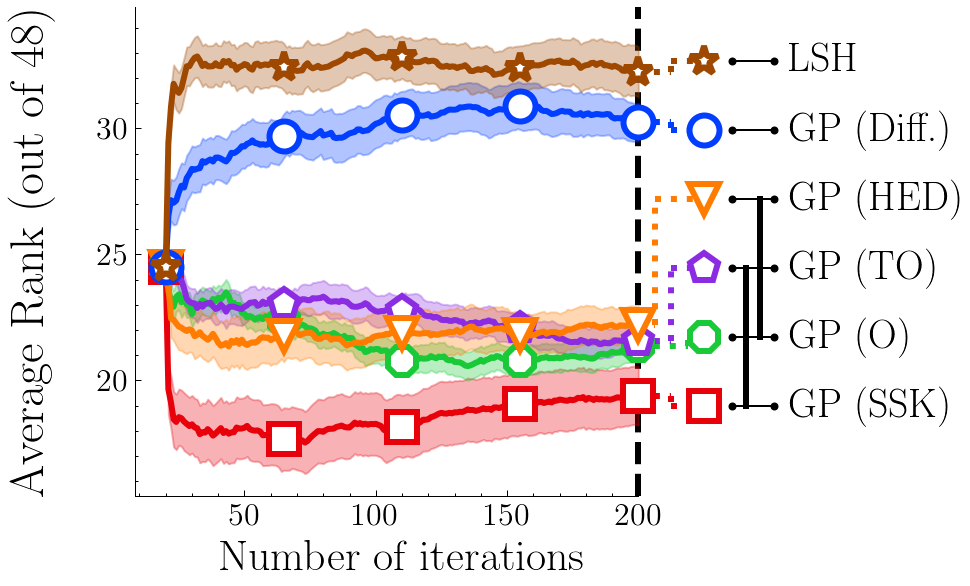

In [43]:
fig, ax = plt.subplots(figsize=(6, 4.5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.12, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_model_comb.pdf")
plt.show()

######  Acq opt

In [44]:
sub_regret_df = all_res.copy()

filtre_out = {"Acq opt": ["no-acq-opt"]}
group_col = ["Acq opt"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

sub_regret_df["rank"] = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])[["f(x*)"]].rank()

In [45]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T

###### Assess statistical difference

In [46]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

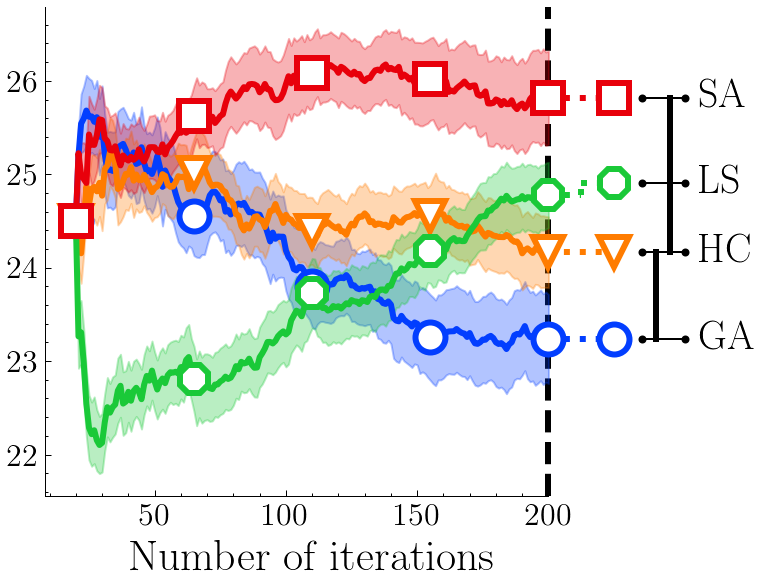

In [47]:
fig, ax = plt.subplots(figsize=(6, 4.5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

# ax.set_ylabel("Average Rank", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.12, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_acqopt_comb.pdf")

plt.show()

###### Trust Region

In [48]:
sub_regret_df = all_res.copy()

filtre_out = {"Model": ["no-model"]}
group_col = ["TR"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

sub_regret_df["rank"] = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])[["f(x*)"]].rank()

In [49]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T

###### Assess statistical difference

In [50]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

 At least 3 sets of measurements must be given for Friedman test, got 2


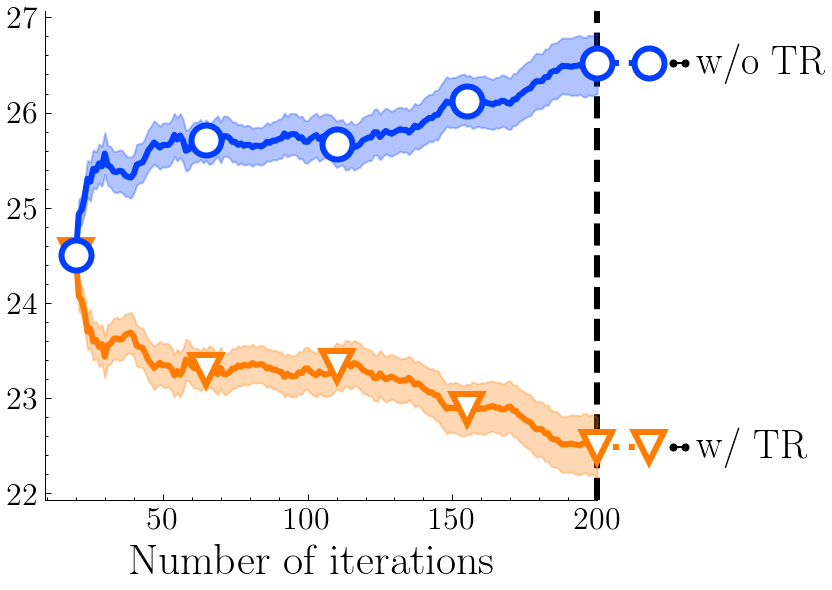

In [51]:
fig, ax = plt.subplots(figsize=(6, 4.5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

# ax.set_ylabel("Average Rank", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.12, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_tr_comb.pdf")
plt.show()

###### Trust Region and model

In [52]:
sub_regret_df = all_res.copy()

filtre_out = {"Model": ["no-model"]}
group_col = ["TR", "Model"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

aux_groupby = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])
sub_regret_df["rank"] = aux_groupby[["f(x*)"]].rank()

counts = aux_groupby.count().values.flatten()
assert np.all(counts[0] == counts)

num_cands = counts[0]

In [53]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T

###### Assess statistical difference

In [54]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

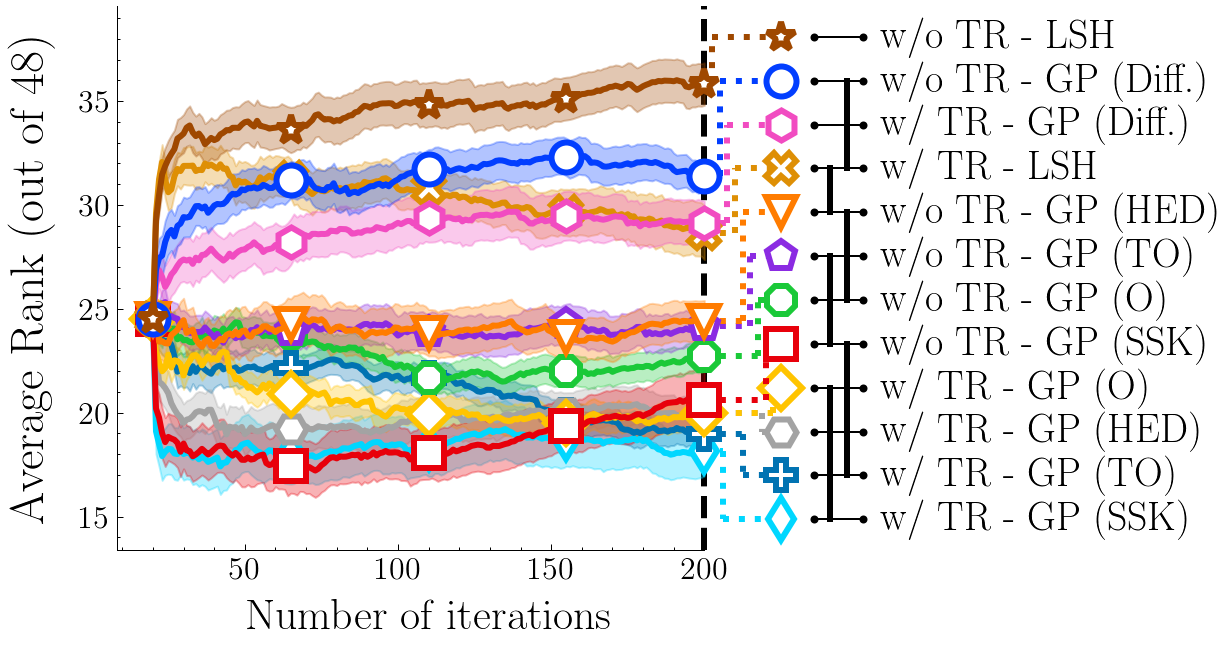

In [55]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.08, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_tr_model_comb.pdf")
plt.show()

###### Trust Region and acq optimization

In [56]:
sub_regret_df = all_res.copy()

filtre_out = {"Model": ["no-model"], "Acq opt": ["no-acq-opt"]}
group_col = ["TR", "Acq opt"]

for k, v in filtre_out.items():
    sub_regret_df = sub_regret_df[~sub_regret_df[k].isin(v)]

group_col_name = " - ".join(group_col)

sub_regret_df[group_col_name] = sub_regret_df[group_col[0]].values
for i in range(1, len(group_col)): 
    sub_regret_df[group_col_name] += " - " + sub_regret_df[group_col[i]].values

aux_groupby = sub_regret_df.groupby(["Task", "Eval Num", "Seed"])
sub_regret_df["rank"] = aux_groupby[["f(x*)"]].rank()

counts = aux_groupby.count().values.flatten()
assert np.all(counts[0] == counts)

num_cands = counts[0]

In [57]:
num_evals = np.arange(20, 201)

opt_to_rank_dict = {}

sub_regret_df = sub_regret_df.groupby(["Task", "Eval Num", "Seed", group_col_name])["rank"].mean().reset_index()

for num_eval in num_evals:
    for opt_name, rank_data  in sub_regret_df[sub_regret_df["Eval Num"] == num_eval].groupby(group_col_name)["rank"]:
        if opt_name not in opt_to_rank_dict:
            opt_to_rank_dict[opt_name] = []
        opt_to_rank_dict[opt_name].append(rank_data.values)

for opt_name in opt_to_rank_dict:
    opt_to_rank_dict[opt_name] = np.array(opt_to_rank_dict[opt_name]).T

In [58]:
eval_budget = 200
pval_threshold = 0.05

sub_regret_eval_df = sub_regret_df[sub_regret_df["Eval Num"] == eval_budget]

# Each row corresponds to a task and seed
ranks_per_task_seed = np.array([v.values for _, v in sub_regret_eval_df.groupby(["Task", "Seed"])["rank"]])

if len(ranks_per_task_seed.T) <= 2:
    print(" At least 3 sets of measurements must be given for Friedman test, got 2")
else:
    friedman_test_pvalue = stats.friedmanchisquare(*ranks_per_task_seed.T).pvalue

    if friedman_test_pvalue >= 0.05:
        print(f"All ranks may be equally distributed: Friedman test p-value={friedman_test_pvalue}")
    
test_results = sp.posthoc_wilcoxon(sub_regret_eval_df, val_col="rank", group_col=group_col_name, zero_method="pratt") 
test_results_map = lambda k1, k2: test_results.loc[k1][k2].item() < pval_threshold

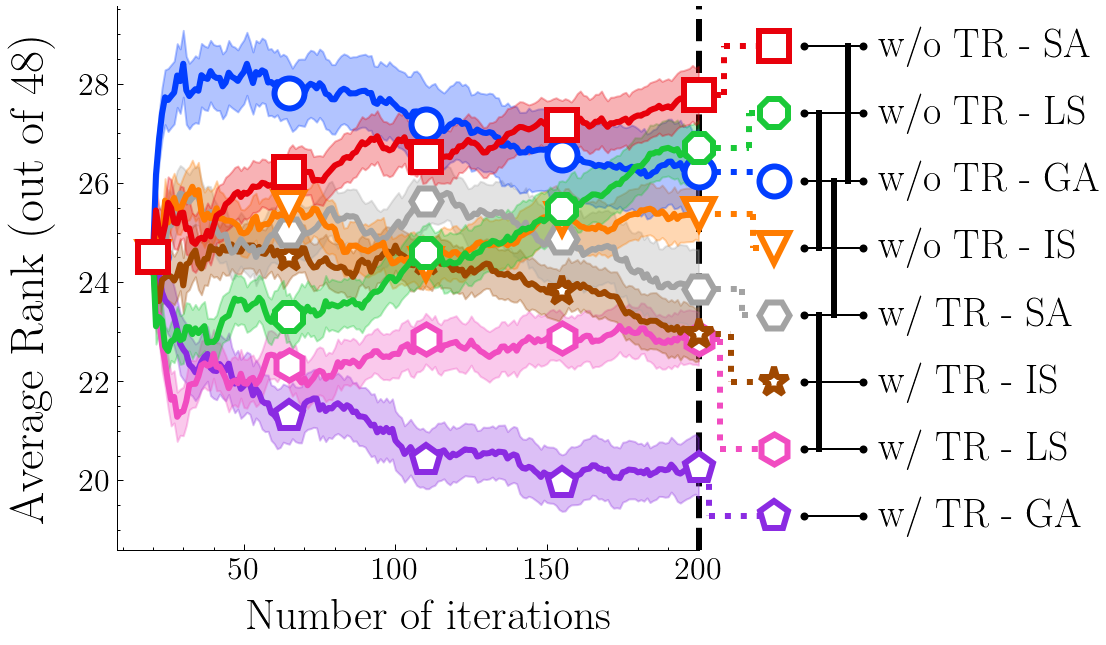

In [59]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_curves_with_ranked_legends(
    ax=ax, data_y=opt_to_rank_dict, data_x=num_evals, show_std_error=True, 
    min_is_the_best=True, data_key_to_label=data_key_to_label, 
    stat_significance_map=test_results_map, label_fontsize=20)

ax.set_ylabel(f"Average Rank (out of {num_cands})", fontsize=24)
ax.set_xlabel("Number of iterations", fontsize=22)
ax.xaxis.set_label_coords(.4, -0.09)
ax.yaxis.set_label_coords(-0.08, .5)

ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f"./{figure_save_name}/rank_tr_acq_comb.pdf")
plt.show()